### Higgs Fit

RooFit example on fitting the 2-photon invariant mass to determine the number of Higgs signal events.

We rea dthe data set consisting of ~ 3000 2-photon invariant mass values from a tetx file (Hgg.txt) which should be in the current directory. 
Otherwise it can be downloaded from here: https://twiki.cern.ch/twiki/pub/Main/ROOTRioTutorial/Hgg.txt

In [1]:
   TTree tree("tree","tree");
   int nevt = tree.ReadFile("Hgg.txt","x");
   if (nevt <= 0) {
      Error("fitHgg","Error reading data from input file ");
   }
   std::cout << "Read " << nevt << " from the file " << std::endl;

Read 30770 from the file 


We make now the RooFit model using the RooWorkspace Factory 

In [2]:
 RooWorkspace w("w");
   w.factory("x[110,160]");  // invariant mass
   
   w.factory("nbackground[10000, 0, 10000]");
   //w.factory("Exponential::z1(x, a1[-1,-10,0])");
   w.var("nbackground")->setVal(nevt);
   w.var("nbackground")->setMin(0.1*nevt);
   w.var("nbackground")->setMax(10*nevt);

   // create exponential model as two components
   w.factory("a1[ 7.5, -500, 500]");
   w.factory("a2[-1.5, -500, 500]");
   w.factory("expr::z('-(a1*x/100 + a2*(x/100)^2)', a1, a2, x)");
   w.factory("Exponential::bmodel(z, 1)");

   // create background model as polynomial
   w.factory("b0[0, -500, 500]");
   w.factory("b1[0, -500, 500]");
   w.factory("b2[0, -500, 500]");
   w.factory("Chebychev::bmodel_pol(x,{b0,b1,b2})"); 

   // signal model   
   w.factory("nsignal[100, 0.0, 1000.0]");
   //w.factory("mass[%f, %f, %f]' % (massguess, massmin, massmax))
   w.factory("mass[130, 110, 150]");
   w.factory("width[1, 0.5, 5]");
   w.factory("Gaussian::smodel(x, mass, width)");
   RooAbsPdf * smodel = w.pdf("smodel");

   w.factory("SUM::model(nbackground*bmodel_pol, nsignal*smodel)");
   RooAbsPdf * model = w.pdf("model");
   RooRealVar * x = w.var("x");


RooFit v3.60 -- Developed by Wouter Verkerke and David Kirkby 
                Copyright (C) 2000-2013 NIKHEF, University of California & Stanford University
                All rights reserved, please read http://roofit.sourceforge.net/license.txt



In [3]:
w.Print();


RooWorkspace(w) w contents

variables
---------
(a1,a2,b0,b1,b2,mass,nbackground,nsignal,width,x)

p.d.f.s
-------
RooExponential::bmodel[ x=z c=1 ] = 0.000616625
RooChebychev::bmodel_pol[ x=x coefList=(b0,b1,b2) ] = 1
RooAddPdf::model[ nbackground * bmodel_pol + nsignal * smodel ] = 0.990099
RooGaussian::smodel[ x=x mean=mass sigma=width ] = 3.72665e-06

functions
--------
RooFormulaVar::z[ actualVars=(a1,a2,x) formula="-(a1*x/100+a2*(x/100)^2)" ] = -7.39125



We create now the RooFit data set importing the data from the ROOT tree.
We import also the data set in the workspace.
We now bin the data in an histogram and we create a RooFit data set from the histogram 

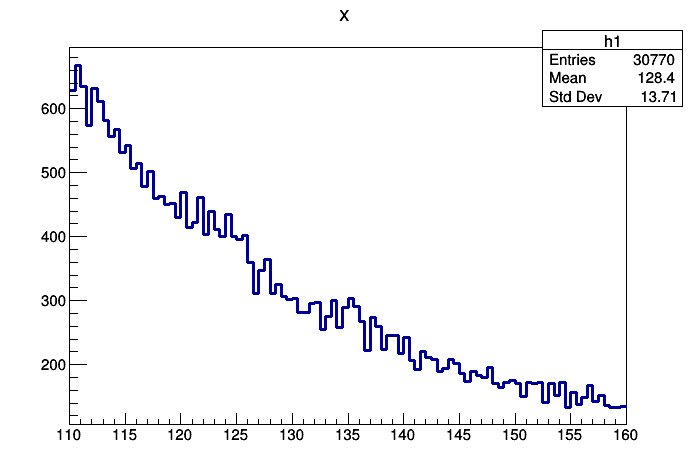

Info in <TCanvas::MakeDefCanvas>:  created default TCanvas with name c1


In [4]:
tree.Draw("x >> h1(100,110,160)");
h1->Draw(); gPad->Draw();

In [5]:
RooDataHist data("bindata","data",*w.var("x"),h1);
w.import(data);

[#1] INFO:DataHandling -- RooDataHist::adjustBinning(bindata): fit range of variable x expanded to nearest bin boundaries: [110,160] --> [110,160]
[#1] INFO:ObjectHandling -- RooWorkspace::import(w) importing dataset bindata


we now fit the data

In [6]:
RooFitResult * r = nullptr;
RooPlot * plot = nullptr;

In [16]:
plot = w.var("x")->frame();
data.plotOn(plot);

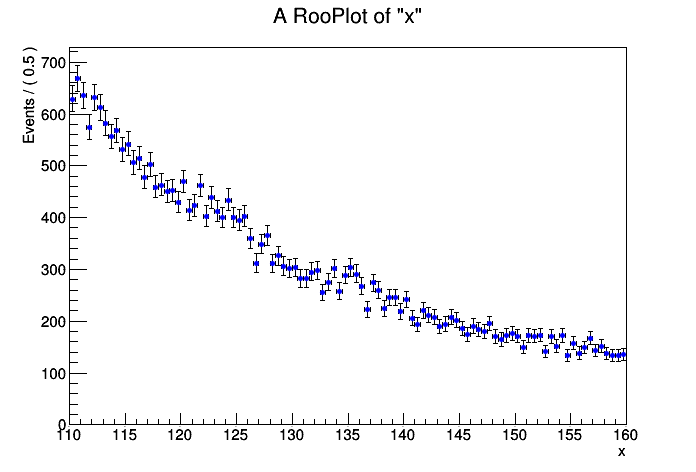

In [8]:
plot->Draw(); c1->Draw();

In [20]:
w.var("mass")->setMin(120);
r = w.pdf("model")->fitTo(data, RooFit::Minimizer("Minuit2"),RooFit::Save(true), RooFit::Offset(true),RooFit::PrintLevel(1));

[#1] INFO:Minization -- p.d.f. provides expected number of events, including extended term in likelihood.
[#1] INFO:Minization -- RooMinimizer::optimizeConst: activating const optimization
[#1] INFO:Minization --  The following expressions will be evaluated in cache-and-track mode: (bmodel_pol,smodel)
Minuit2Minimizer: Minimize with max-calls 3500 convergence for edm < 1 strategy 1
[#1] INFO:Minization -- RooNLLVar::evaluatePartition(nll_model_bindata) first = 0 last = 100 Likelihood offset now set to -170094
MnSeedGenerator: for initial parameters FCN = 0
MnSeedGenerator: Initial state:   - FCN =                0 Edm =      16.0886 NCalls =     29
MnSeedGenerator: Negative G2 found - new state:   - FCN =  -9.152328892407 Edm =      7.31778 NCalls =     92
VariableMetric: start iterating until Edm is < 0.001
VariableMetric: Initial state   - FCN =  -9.152328892407 Edm =      7.31778 NCalls =     92
VariableMetric: Iteration #   0 - FCN =  -9.152328892407 Edm =      7.31778 NCalls =    

Info in <Minuit2>: Minuit2Minimizer::Hesse : Hesse is valid - matrix is accurate


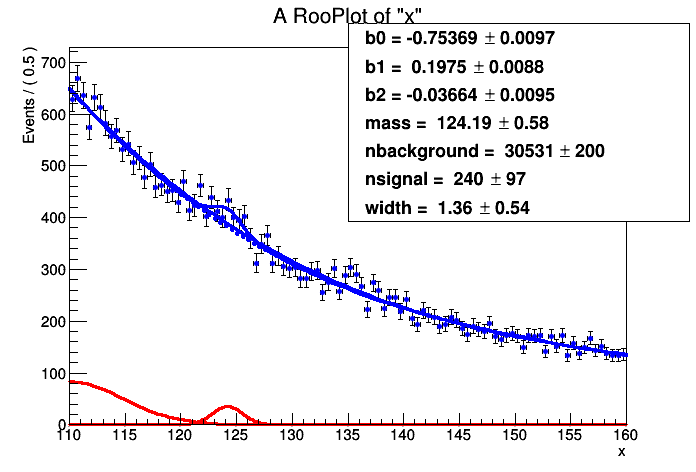

[#1] INFO:Plotting -- RooAbsPdf::plotOn(model) directly selected PDF components: (bmodel_pol)
[#1] INFO:Plotting -- RooAbsPdf::plotOn(model) indirectly selected PDF components: ()
[#1] INFO:Plotting -- RooAbsPdf::plotOn(model) directly selected PDF components: (smodel)
[#1] INFO:Plotting -- RooAbsPdf::plotOn(model) indirectly selected PDF components: ()


In [21]:

model->plotOn(plot);
//w.pdf("bmodel_pol")->plotOn(plot);
model->plotOn(plot, RooFit::Components("bmodel_pol"),RooFit::LineStyle(kDashed));
model->plotOn(plot, RooFit::Components("smodel"),RooFit::LineColor(kRed));
model->paramOn(plot);

plot->Draw();
c1->Draw();

Before saving the workspace we create the RooStats model config object which is needed for the RooStats tools.

In [ ]:
RooStats::ModelConfig mc("ModelConfig",&w);
mc.SetPdf(*w.pdf("model"));
mc.SetParametersOfInterest(*w.var("nsignal"));
mc.SetObservables(*w.var("x"));
// define set of nuisance parameters
w.defineSet("nuisParams","a1,a2,nbackground");

mc.SetNuisanceParameters(*w.set("nuisParams"));
mc.Print();

We want to semplify the H->gg model (for speeding-up ) the RooStats calculations, by assuming that the mass and the sigma of the signal are known and do not vary in the fits. We set them to constant

In [ ]:
w.var("mass")->setConstant(true);
w.var("width")->setConstant(true);
w.import(mc);

In [ ]:
w.writeToFile("HiggsBinModel.root",true);
w.Print();